In [1]:
import numpy as np 
from tqdm import tqdm 
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST
import matplotlib.pyplot as plt    

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [3]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches **2 , h*w // n_patches **2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i+1) * patch_size, j * patch_size: (j+1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()

    return patches

In [4]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d, dtype=torch.double)
    
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i/(10000 ** (j/d))) if j%2 ==0 else np.cos(i/(10000 ** ((j-1)/d)))
        return result


get_positional_embeddings(30,30)

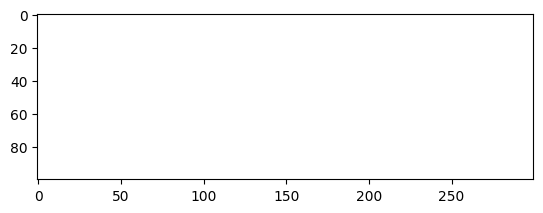

In [5]:
    plt.imshow(get_positional_embeddings(100,300), cmap = "hot", interpolation = "nearest")
    plt.show()

In [6]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads = 2):
        super(MyMSA,self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension{d} into {n_heads} heads"

        d_head = int(d/ n_heads)

        self.q_mappings = nn.ModuleList([nn.Linear(d_head,d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head,d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head,d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim = -1)

    def forward(self, sequences):

        result = []
        for sequence in sequences:
            seq_result = []

            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head* self.d_head: (head+1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head **0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))

        return torch.cat([torch.unsqueeze(r , dim =0) for r in result])


In [7]:
class myViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio = 4):
        super(myViTBlock,self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio* hidden_d, hidden_d)
        )



    def forward(self, x):
        #print('x:',x.dtype,x.shape)
        out =x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out


In [8]:
class MyViT(nn.Module):
    def __init__(self, chw =(1,28,28), n_patches = 7, n_blocks =2, hidden_d =8, n_heads =2, out_d =10):
        super(MyViT, self).__init__()

        self.chw = chw
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        assert chw[1] % n_patches ==0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches ==0, "Input shape not entirely divisible by number of patches"

        self.patch_size = (chw[1]/ n_patches, chw[2]/ n_patches)

        # 1) Linear mapper

        self.input_d = int(chw[0] * self.patch_size[0]* self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding

        self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 +1,self.hidden_d)))
        self.pos_embed.requires_grad = False

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([myViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

        # 5) Classification MLP

        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d,out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to('cuda')
        tokens = self.linear_mapper(patches)

        tokens = torch.stack([torch.vstack((self.class_token,tokens[i])) for i in range(len(tokens))])

        pos_embed = self.pos_embed.repeat(n,1,1)
        out = tokens + pos_embed

        # Transformer Blocks
        #print('ssLL:',out.shape)
        for block in self.blocks:
            #print('jj:',block)
            out = block(out)

        out = out[:,0]

        return self.mlp(out)
        #pass

        

In [9]:
 if __name__ == '__main__':

      #model = myViTBlock(hidden_d = 8, n_heads = 2)
    model = MyViT(chw = (1, 28, 28), n_patches = 7, n_blocks = 2,    hidden_d = 8,    n_heads =2,    out_d = 10)

    model.cuda().float()
    x = torch.randn(1,1,28,28, device='cuda')#.cuda()
    #print(model(x).shape)

/tmp/ipykernel_50199/3931125494.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 +1,self.hidden_d)))


In [12]:
def main():

    transform = ToTensor()

    train_set = MNIST(root='./datasets', train=True, download=False,transform=transform)
    test_set = MNIST(root='./datasets', train = False, download=False, transform = transform)

    train_loader = DataLoader(train_set, shuffle = True, batch_size =8192)
    test_loader = DataLoader(test_set, shuffle= False, batch_size =16384)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('device:',device)
    model = MyViT(
    chw = (1, 28, 28),
    n_patches = 7,
    n_blocks = 2,
    hidden_d = 8,
    n_heads =2,
    out_d = 10
    )
    model.to(device).float()

    N_EPOCHS= 5

    LR =0.005

    optimizer = Adam(model.parameters(), lr = LR)
    criterion = CrossEntropyLoss()

    for epoch in tqdm(range(N_EPOCHS), desc = "Training"):
        train_loss = 0.0
        for batch in tqdm(train_loader, desc = f"Epoch {epoch + 1} in training", leave = True):
            x, y = batch
            
#            x,y =x.double(), y.double()
            x, y  = x.to(device), y.to(device)
            #x, y = x.double().to(device), y.double().to(device)
            #print('x:',x.dtype,x.shape)

            #print('dd:',x.get_device())
            #print(model.device())
            print('x:',x.shape)
            y_hat = model(x)

            loss = criterion(y_hat,y)

            train_loss += loss.detach().cpu().item()/ len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{N_EPOCHS} loss:{train_loss:.2f}")
# Test loop

    with torch.no_grad():
        correct, total = 0,0
        test_loss =0.0
        for batch in tqdm(test_loader, desc = "Testing"):
            x,y = batch
            x,y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat,y)
            test_loss += loss.detach().cpu().item()/len(test_loader)

            correct += torch.sum(torch.argmax(y_hat,dim =1) ==y ).detach().cpu().item()
            total += len(x)

        print(f"Test loss:{ test_loss:.2f}")
        print(f"Test accuracy: {correct / total *100:.2f}%")


In [13]:
 if __name__ == '__main__':
    main()

/tmp/ipykernel_50199/3931125494.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 +1,self.hidden_d)))


device: cuda


Training:   0%|          | 0/5 [00:00<?, ?it/s]

x: torch.Size([8192, 1, 28, 28])


x: torch.Size([8192, 1, 28, 28])


x: torch.Size([8192, 1, 28, 28])


x: torch.Size([8192, 1, 28, 28])


x: torch.Size([8192, 1, 28, 28])


x: torch.Size([8192, 1, 28, 28])


x: torch.Size([8192, 1, 28, 28])


x: torch.Size([2656, 1, 28, 28])


Training:  20%|██        | 1/5 [06:51<27:24, 411.08s/it]

Epoch 1/5 loss:2.30


x: torch.Size([8192, 1, 28, 28])


x: torch.Size([8192, 1, 28, 28])


x: torch.Size([8192, 1, 28, 28])


x: torch.Size([8192, 1, 28, 28])


x: torch.Size([8192, 1, 28, 28])


x: torch.Size([8192, 1, 28, 28])


x: torch.Size([8192, 1, 28, 28])


x: torch.Size([2656, 1, 28, 28])


Training:  40%|████      | 2/5 [13:39<20:28, 409.60s/it]

Epoch 2/5 loss:2.27


x: torch.Size([8192, 1, 28, 28])


x: torch.Size([8192, 1, 28, 28])


x: torch.Size([8192, 1, 28, 28])


x: torch.Size([8192, 1, 28, 28])


x: torch.Size([8192, 1, 28, 28])


Training:  40%|████      | 2/5 [17:25<26:07, 522.50s/it]


KeyboardInterrupt: 